# Ecommerce A/B Testing


In [136]:
import os
import pandas as pd
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    DATA_PATH = "/kaggle/input/ecommerce-ab-testing-2022-dataset1/ecommerce_ab_testing_2022_dataset1"
else:
    DATA_PATH = "data/ecommerce_ab_testing_2022_dataset1"

df_ab = pd.read_csv(f'{DATA_PATH}/ab_data.csv')
df_countries = pd.read_csv(f'{DATA_PATH}/countries.csv')


## Data cleaning

In [137]:
df_ab.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


The old landing page is the control group and the new landing page is the treatment group. We remove errors where they are mismatched.

In [138]:
irregular_control_count = len(df_ab[((df_ab['landing_page'] == 'old_page') & (df_ab['group'] == 'treatment'))])
irregular_treatment_count = len(df_ab[((df_ab['landing_page'] == 'new_page') & (df_ab['group'] == 'control'))])
print(f'Removing {irregular_control_count} rows from treatment group')
df_ab = df_ab[~((df_ab['landing_page'] == 'old_page') & (df_ab['group'] == 'treatment'))]
print(f'Removing {irregular_treatment_count} rows from control group')
df_ab = df_ab[~((df_ab['landing_page'] == 'new_page') & (df_ab['group'] == 'control'))]


Removing 1965 rows from treatment group
Removing 1928 rows from control group


With errors removed, we only require the user_id, group and converted columns for further analysis.

In [139]:
df_ab.drop(columns=['landing_page', 'timestamp'], inplace=True)
df_ab.info()
print('Total number of unique users is ' + str(df_ab['user_id'].nunique()))

<class 'pandas.core.frame.DataFrame'>
Index: 290587 entries, 0 to 294479
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290587 non-null  int64 
 1   group      290587 non-null  object
 2   converted  290587 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.9+ MB
Total number of unique users is 290585


Comparing the total number of rows with unique users, it appears there may be a couple of duplicates

In [140]:
print('Removing the following duplicates ') 
print(df_ab[df_ab.duplicated()])
df_ab.drop_duplicates();

Removing the following duplicates 
        user_id      group  converted
2893     773192  treatment          0
294478   759899  treatment          0


In [141]:
print('Converting data type to boolean for the conversion column')
df_ab['converted'] = df_ab['converted'].astype(bool)
print(df_ab['converted'].value_counts())

Converting data type to boolean for the conversion column
converted
False    255834
True      34753
Name: count, dtype: int64


# Visualization

We will inspect the counts of conversions for each group and visualize it in a bar chart

In [142]:
grouped_percentage = df_ab.groupby(['group', 'converted']).size().reset_index(name='count')
grouped_percentage['percent'] = grouped_percentage.groupby('group')['count'].transform(lambda x: (x / x.sum())*100)
grouped_percentage

,group,converted,count,percent
0,control,False,127785,87.961370
1,control,True,17489,12.038630
2,treatment,False,128049,88.119439
3,treatment,True,17264,11.880561


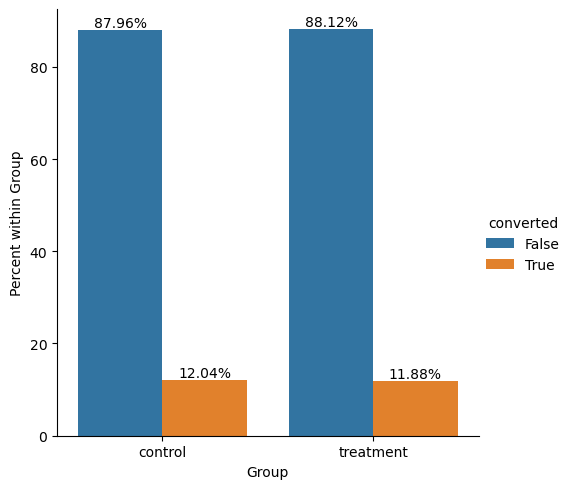

In [143]:
g = sns.catplot(data=grouped_percentage, x='group', y='percent', hue='converted', kind='bar')
g.set_axis_labels("Group", "Percent within Group")
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt="%2.2f%%")

On casual observation, the conversion rate of both control and treatment groups are very close to each other with the treatment group seemingly worse than the control. But we have to test the statistical significance of this result as it only represents a sample of the population. 

In other words, we have to confirm that the difference is not due to random chance.

# Hypothesis Testing

Since we are comparing proportions of the categorical variable 'converted' we can use either the chi-square test or the Z-test for proportions.

We choose the Z-test for proportions for the following reasons:
- The sample size is large enough (> 100,000 rows per group)
- We can infer whether the treatment outperforms the control (or vice versa)


## Null and Alternative Hypothesis

We define the null hypothesis as   
$$\pi_1\geq\pi_2$$
 where   
 $\pi_1$ is the population conversion rate of the control group    
 $\pi_2$ is the population conversion rate of the treatment group

The alternative hypothesis is 
$$\pi_1\lt\pi_2$$

This means that if the conversion rate of the control group is greater or equal to the treatment then there is no need to change it.
We reject the null hypothesis when there is sufficient evidence that the treatment group conversion rate is higher

## Z-Test for proportion

We will use a one-tailed Z-test with a 0.05 level of significance ( $\alpha$ ) which gives us 95% (1-$\alpha$) confidence.

In [153]:
# Build the summary table
contingency_table = df_ab.groupby(['group','converted']).size().unstack()
contingency_table.columns = ['not_converted', 'converted']

# Get success and totals
success = contingency_table['converted'].values
nobs = contingency_table.sum(axis=1).values

print(contingency_table)
print("Groups", list(contingency_table.index))
print("Converted counts", success)
print("Total counts", nobs)

z_stat, p_value = proportions_ztest(count=success, nobs=nobs, alternative='smaller')
print(f"Z-Statistic {z_stat:4f}")
print(f"p value {p_value:4f}")

           not_converted  converted
group                              
control           127785      17489
treatment         128049      17264
Groups ['control', 'treatment']
Converted counts [17489 17264]
Total counts [145274 145313]
Z-Statistic 1.312974
p value 0.905404


The p-value of 0.905 is much higher than the the level of significance. We fail to reject the null hypothesis.

**We do not sufficient evidence to prove than treatment outperforms the control**

# Conclusion

The A/B test result shows that the new landing page does not increase conversion.